In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

#for replicability purposes
tf.random.set_seed(91195003)
#for an easy reset backend session state
tf.keras.backend.clear_session()

In [2]:
n_variate = 1

In [3]:

#Load dataset
def load_dataset(path=r'overdoses.csv'):
    return pd.read_csv(path)

In [4]:
#split data into training and validation sets
def split_data(training, perc=10):
    train_idx = np.arange(0, int(len(training)*(100-perc)/100))
    val_idx = np.arange(int(len(training)*(100-perc)/100+1), len(training))
    return train_idx, val_idx

In [30]:
def prepare_data(df):
    df_aux = df
    df_aux["Date"] = pd.to_datetime(df_aux["Date"])
    df_aux = df_aux.set_index('Date')
    # por obitos como primeira coluna
    df_aux = df_aux.reindex(columns=['Cocaine (T40.5)', 'Heroin (T40.1)', 'Methadone (T40.3)', 'Natural & semi-synthetic opioids (T40.2)', 'Natural & semi-synthetic opioids, incl. methadone (T40.2, T40.3)', 'Natural, semi-synthetic, & synthetic opioids, incl. methadone (T40.2-T40.4)', 'Number of Drug Overdose Deaths', 'Opioids (T40.0-T40.4,T40.6)', 'Psychostimulants with abuse potential (T43.6)', 'Synthetic opioids, excl. methadone (T40.4)'])
    # drop de features com correlação alta a outras
    df_aux = df_aux.drop(columns=['Natural & semi-synthetic opioids (T40.2)', 'Natural & semi-synthetic opioids, incl. methadone (T40.2, T40.3)'])
    
    # df_aux = df_aux.drop(columns=[ 'obitos_0_9_f', 'obitos_10_19_f', 'obitos_10_19_m', 'obitos_20_29_f', 'obitos_20_29_m',
    #                               'ativos', 'Partially_cloudy', 'commercial_flights'])
    return df_aux

In [31]:
# def data_normalization(df, norm_range=(-1, 1)):
#   #[-1, 1] for LSTM due to the internal use of tanh by the memory cell
#   scaler = MinMaxScaler(feature_range=norm_range)
#   df = scaler.fit_transform(df)
#   return scaler

In [32]:
def data_normalization(df, norm_range=(-1, 1)):
    #[-1, 1] for LSTM due to the internal use of tanh by the memory cell
    scaler = MinMaxScaler(feature_range=norm_range)
    colunas = [x for x in df.columns if x != 'Number of Drug Overdose Deaths']
    for col in colunas:
        df[[col]] = scaler.fit_transform(df[[col]])
    df[['Number of Drug Overdose Deaths']] = scaler.fit_transform(df[['Number of Drug Overdose Deaths']])
    return scaler

In [33]:
#plot learning curve
def plot_learning_curves(history, epochs):
    #accuracies and losses
    #dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse'])
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    mae=history.history['mae']
    val_mae=history.history['val_mae']
    rmse=history.history['rmse']
    val_rmse=history.history['val_rmse']
    epochs_range = range(epochs)
    #creating figure
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,2)
    plt.plot(epochs_range,loss,label='Training Loss')
    plt.plot(epochs_range,val_loss,label='Validation Loss')
    plt.plot(epochs_range,mae,label='Training MAE')
    plt.plot(epochs_range,val_mae,label='Validation MAE')
    plt.plot(epochs_range,rmse,label='Training RMSE')
    plt.plot(epochs_range,val_rmse,label='Validation RMSE')
    plt.legend(loc='upper right')
    plt.title('Training/Validation Loss')
    plt.show()

In [34]:
#Plot time series data
def plot_deaths_cases(data):
    plt.figure(figsize=(8,6))
    plt.plot(range(len(data)), data)
    plt.title('Deaths by overdose')
    plt.ylabel('Deaths')
    plt.xlabel('Months')
    plt.show()

In [35]:
#Preparing the dataset for the LSTM
def to_supervised(df, timesteps):
    data = df.values
    X, y = list(), list()
    #iterate over the training set to create X and y
    dataset_size = len(data)
    for curr_pos in range(dataset_size):
        #end of the input sequence is the current position + the number of timesteps of the input sequence
        input_index = curr_pos + timesteps
        #end of the labels corresponds to the end of the input sequence + 1
        label_index = input_index + 1
        #if we have enough data for this sequence
        if label_index < dataset_size:
            X.append(data[curr_pos:input_index, :])
            y.append(data[input_index:label_index, 0])
            # y.append(data[input_index:label_index, 0:n_variate])

    #using np.float32 for GPU performance
    return np.array(X).astype('float32'), np.array(y).astype('float32')

In [36]:
#Building the model
def rmse(y_true, y_pred):
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))


In [37]:
def build_model(timesteps, features, h_neurons=64, activation='tanh'):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(h_neurons, activation=activation, input_shape=(timesteps, features), return_sequences=True))
    #Add a new layer
    model.add(tf.keras.layers.LSTM(32, activation=activation ,return_sequences=False))
    #
    model.add(tf.keras.layers.Dense(h_neurons, activation=activation))
    # model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(1, activation='linear'))
    #model summary (and save it as PNG)
    tf.keras.utils.plot_model(model, 'Covid_model.png', show_shapes=True)
    return model

In [38]:
#Compiling and fit the model
def compile_and_fit(model, epochs, batch_size):
    #compile
    model.compile(loss = rmse, optimizer = tf.keras.optimizers.Adam(), metrics = ['mae', rmse])
    #fit
    hist_list = list()
    loss_list = list()

    #callback
    #saving in Keras HDF5 (or h5), a binary data format
    callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath='my_model_{epoch}_{val_loss:.3f}.h5',#path where to save model
        save_best_only=True,#overwrite the current checkpoint if and only if
        monitor='val_loss',#the val_loss score has improved
        save_weights_only=False,#if True, only the weigths are saved
        verbose=1,#verbosity mode
        period=5 #save ony at the fifth epoch (5 em 5 epocas) 
        )#,
    #interrupt training if loss stops improving for over 2 epochs
    #tf.keras.callbacks.EarlyStopping(patience=9, monitor='cost')
    ]

    #Time Series Cross Validator
    tscv = TimeSeriesSplit(n_splits=cv_splits)
    for train_index, test_index in tscv.split(X):
        train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets
        #build data
        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]
        X_test, y_test = X[test_index], y[test_index]

        #print("x_val::::",X_val,"\n","y_val:",y_val,"\n")

        history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, shuffle=False)
        # history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, shuffle=False, callbacks=callbacks)
        metrics = model.evaluate(X_test, y_test)


        plot_learning_curves(history, epochs)
        hist_list.append(history)


    return model, hist_list

In [39]:
#Main Execution
#the dataframes
df_raw = load_dataset()
df_data = prepare_data(df_raw)
df = df_data.copy()
n_variate = len(df.columns)

scaler = data_normalization(df) #scaling data to [-1, 1]

In [40]:
df

,Cocaine (T40.5),Heroin (T40.1),Methadone (T40.3),"Natural, semi-synthetic, & synthetic opioids, incl. methadone (T40.2-T40.4)",Number of Drug Overdose Deaths,"Opioids (T40.0-T40.4,T40.6)",Psychostimulants with abuse potential (T43.6),"Synthetic opioids, excl. methadone (T40.4)"
Date,,,,,,,,
2015-01-01,-1.000000,-1.000000,0.976540,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2015-02-01,-0.985804,-0.920446,0.856305,-0.989963,-0.989366,-0.983346,-0.994472,-0.986004
2015-03-01,-0.965545,-0.859108,0.900293,-0.975594,-0.964467,-0.963338,-0.978357,-0.972097
2015-04-01,-0.939076,-0.746097,0.941349,-0.950934,-0.935514,-0.926205,-0.967888,-0.950722
2015-05-01,-0.927394,-0.670260,1.000000,-0.929789,-0.906825,-0.896487,-0.954949,-0.933462
...,...,...,...,...,...,...,...,...
2020-04-01,0.814270,0.185502,-0.542522,0.569562,0.531914,0.523745,0.643475,0.617225
2020-05-01,0.919409,0.288476,-0.079179,0.731129,0.708262,0.706350,0.745692,0.757367
2020-06-01,0.972052,0.283643,0.181818,0.834662,0.818493,0.821279,0.822031,0.852748


In [41]:
#Recursive Multi-Step Forecast!!!
def forecast(model, df, timesteps, multisteps, scaler):
    input_seq = np.array(df[-timesteps:].values) #getting the last sequence of known value
    inp = input_seq
    #print("Input_seq: ",inp)
    forecasts = list()

    #multisteps tells us how many iterations we want to perform, i.e., how many days we want to predict
    for step in range(1, multisteps+1):
        inp = inp.reshape(1,timesteps,n_variate)
        yhat = model.predict(inp) #dá o valor predito normalizado
        yhat_desnormalized = scaler.inverse_transform(yhat) #dá valor predito desnormalizado
        forecasts.append(yhat_desnormalized) #adicionar previsao à lista final de previsões
        # se for necessário prever mais do que 1 semana
        # list_yhat = [yhat[0][i] for i in range(len(yhat[0]))]
        # print('list_yhat:')
        # print(list_yhat)
        # #preparar novo input para fazer previsão para a semana seguinte
        # inp= np.append(inp[0],[list_yhat],axis=0) #adiciona previsão recente ao input
        # inp = inp[-timesteps:] #vai ao input buscar os ultimos timesteps registados
        # print('forecasts:')
        # print(forecasts)
    return forecasts



In [45]:
def plot_forecast(data, forecasts):
    plt.figure(figsize=(20,8))
    plt.plot(range(len(data)), data['Number of Drug Overdose Deaths'], color='green', label='True value')
    plt.plot(range(len(data)-1, len(data)+len(forecasts)-1), forecasts, color='red', label='Forecasts')
    plt.title('Deaths by overdose')
    plt.ylabel('Deaths')
    plt.xlabel('Meses')
    plt.legend()
    plt.show()

# Tunning

In [46]:
tunning_dict = {               
                1: {'timesteps' : 30, 'multisteps' : 1, 'cv_splits': 2, 'epochs' : 25,  'batch_size' : 2 }#,
                # 2: {'timesteps' : 4, 'multisteps' : 4, 'cv_splits' : 10, 'epochs' : 50,  'batch_size' : 2 },
                # 3: {'timesteps' : 4, 'multisteps' : 4, 'cv_splits' : 10, 'epochs' : 100,  'batch_size' : 2 },

                #
                # 4: {'timesteps' : 14, 'multisteps' : 100, 'cv_splits': 10, 'epochs' : 10,  'batch_size' : 2 },
                # 5: {'timesteps' : 14, 'multisteps' : 100, 'cv_splits' : 10, 'epochs' : 50,  'batch_size' : 2 },
                # 6: {'timesteps' : 14, 'multisteps' : 100, 'cv_splits' : 10, 'epochs' : 100,  'batch_size' : 2 }#,
                #
                #7: {'timesteps' : 30, 'multisteps' : 100, 'cv_splits': 5, 'epochs' : 10,  'batch_size' : 1 },
                #8: {'timesteps' : 30, 'multisteps' : 100, 'cv_splits' : 5, 'epochs' : 50,  'batch_size' : 1 },
                #9: {'timesteps' : 30, 'multisteps' : 100, 'cv_splits' : 5, 'epochs' : 100,  'batch_size' : 1 }

                }
# record da history de cada modelo
record = {}

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Epoch 1/25
6/6 [==============================] - 7s 317ms/step - loss: 0.0654 - mae: 0.0634 - rmse: 0.0667 - val_loss: 0.1474 - val_mae: 0.1474 - val_rmse: 0.1474
Epoch 2/25
6/6 [==============================] - 0s 41ms/step - loss: 0.1511 - mae: 0.1501 - rmse: 0.1507 - val_loss: 0.1193 - val_mae: 0.1193 - val_rmse: 0.1193
Epoch 3/25
6/6 [==============================] - 0s 37ms/step - loss: 0.0325 - mae: 0.0314 - rmse: 0.0322 - val_loss: 0.0023 - val_mae: 0.0023 - val_rmse: 0.0023
Epoch 4/25
6/6 [==============================] - 0s 38ms/step - loss: 0.0108 - mae: 0.0099 - rmse: 0.0109 - val_loss: 0.0153 - val_mae: 0.0153 - val_rmse: 0.0153
Epoch 5/25
6/6 [==============================] - 0s 35ms/step - loss: 0.1221 - mae: 0.1218 - rmse: 0.1223 - val_loss: 0.0594 - val_mae: 0.0594 - val_rmse: 0.0594
Epoch 6/25
6/6 [====================

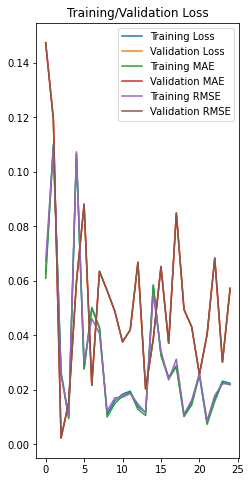

Epoch 1/25
11/11 [==============================] - 4s 125ms/step - loss: 0.0269 - mae: 0.0263 - rmse: 0.0269 - val_loss: 0.0334 - val_mae: 0.0321 - val_rmse: 0.0334
Epoch 2/25
11/11 [==============================] - 0s 20ms/step - loss: 0.0682 - mae: 0.0680 - rmse: 0.0682 - val_loss: 0.0432 - val_mae: 0.0425 - val_rmse: 0.0432
Epoch 3/25
11/11 [==============================] - 0s 19ms/step - loss: 0.0192 - mae: 0.0183 - rmse: 0.0192 - val_loss: 0.0107 - val_mae: 0.0076 - val_rmse: 0.0107
Epoch 4/25
11/11 [==============================] - 0s 23ms/step - loss: 0.0371 - mae: 0.0365 - rmse: 0.0371 - val_loss: 0.0239 - val_mae: 0.0219 - val_rmse: 0.0239
Epoch 5/25
11/11 [==============================] - 0s 20ms/step - loss: 0.0556 - mae: 0.0551 - rmse: 0.0556 - val_loss: 0.0134 - val_mae: 0.0109 - val_rmse: 0.0134
Epoch 6/25
11/11 [==============================] - 0s 19ms/step - loss: 0.0208 - mae: 0.0197 - rmse: 0.0208 - val_loss: 0.0376 - val_mae: 0.0365 - val_rmse: 0.0376
Epoch 7/2

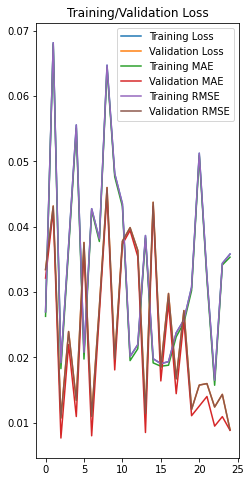

[array([[75180.85]], dtype=float32)]
Previsões:
[75180.85]


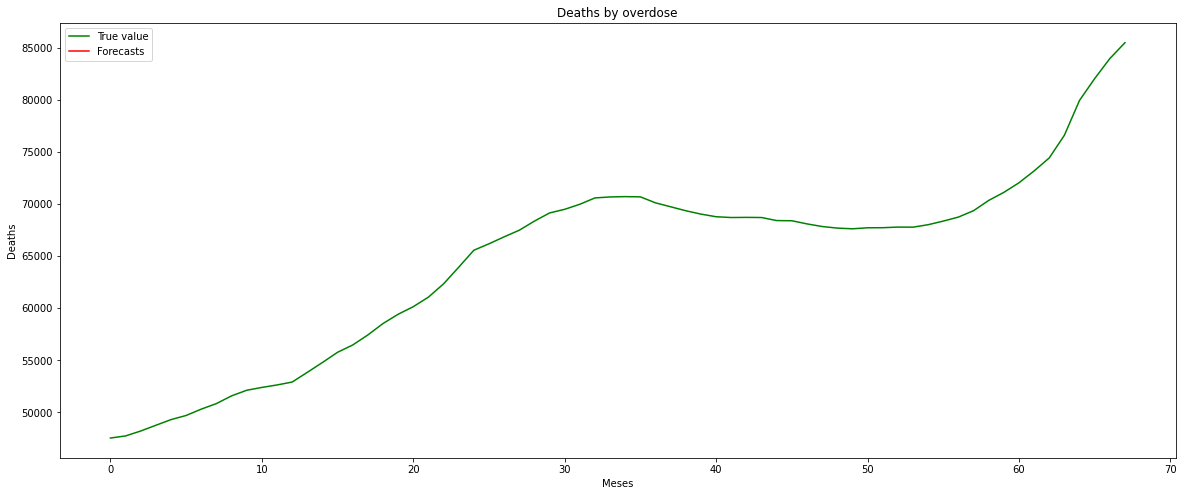

In [47]:
for t in tunning_dict:
    #print(record[r])
    # fitting the model
    timesteps = tunning_dict[t]['timesteps']
    epochs = tunning_dict[t]['epochs']
    batch_size= tunning_dict[t]['batch_size']
    multisteps= tunning_dict[t]['multisteps']
    cv_splits = tunning_dict[t]['cv_splits']
    #print(timesteps,epochs,batch_size,cv_splits)

    X, y = to_supervised(df, timesteps)

    model = build_model(timesteps, n_variate)
    model, history = compile_and_fit(model, epochs, batch_size)
    #print("df: ",df.shape," timesteps",timesteps," multisteps ",multisteps)
    forecasts = forecast(model, df, timesteps, multisteps, scaler)

    print(forecasts)

    prev = []

    #plot do valor previsto da ação de Open
    for f in forecasts:
        prev.append(f[0][0])

    print('Previsões:')
    print(prev)
    plot_forecast(df_raw, prev)

    #Scorer
  

    record[t] = history

In [48]:
id_tunning = 1
id_split =1

final_dict = {}

for r in record:
#print(tunning_dict[1]['epochs'])
    loss = []
    mae =[]
    rmse = []
    val_loss = []
    val_mae = []
    val_rmse = []

    for h in record[r]:
        #print("Tunning ID:  ",id_tunning," Split ID: ",id_split)
        #plot_learning_curves(h, tunning_dict[id_tunning]['epochs'])
        #['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse']
        #print("loss: ",sum(h.history['loss'])/len(h.history['loss'])," MAE: ",sum(h.history['mae'])/len(h.history['mae'])," RMSE: ",sum(h.history['rmse'])/len(h.history['rmse'])," VAL_LOSS: ",sum(h.history['val_loss'])/len(h.history['val_loss'])," VAL_MAE: ",sum(h.history['val_mae'])/len(h.history['val_mae'])," VAL_RMSE: ",sum(h.history['val_rmse'])/len(h.history['val_rmse']))
        loss.append(sum(h.history['loss'])/len(h.history['loss']))
        mae.append(sum(h.history['mae'])/len(h.history['mae']))
        rmse.append(sum(h.history['rmse'])/len(h.history['rmse']))
        val_loss.append(sum(h.history['val_loss'])/len(h.history['val_loss']))
        val_mae.append(sum(h.history['val_mae'])/len(h.history['val_mae']))
        val_rmse.append(sum(h.history['val_rmse'])/len(h.history['val_rmse']))
        id_split+=1
    id_split=1
  
    final_dict[id_tunning]=[sum(loss)/len(loss), sum(mae)/len(mae),sum(rmse)/len(rmse),sum(val_loss)/len(val_loss),sum(val_mae)/len(val_mae), sum(val_rmse)/len(val_rmse)]

    id_tunning=id_tunning+1



In [49]:
for f in final_dict:
    print("Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE")
    print("ID tunning: ",f, " Valores: ",final_dict[f],"\n")

final_df = pd.DataFrame.from_dict(final_dict, orient='index')
final_df.columns = ['Loss','MAE','RMSE','VAL_LOSS','VAL_MAE','VAL_RMSE']
final_df

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  1  Valores:  [0.03296806879341602, 0.03237964582629502, 0.03300312681123614, 0.03872002705931664, 0.03787203490734101, 0.03872002705931664] 



,Loss,MAE,RMSE,VAL_LOSS,VAL_MAE,VAL_RMSE
1,0.032968,0.03238,0.033003,0.03872,0.037872,0.03872


In [50]:
#Results metrics to a file
final_df.to_csv(r"resultados_lstm_overdoses.csv",index=True)